### by F. Boray TEK, June 2019

---
**English:**

----



**To observe training of the weights of a fully connected neuron in the presence of redundant input signals. The notebook plots before and after training weights
in a simple dense network to classify augmented (noise padded) MNIST images.**

This notebook performs a basic experiment by

1) Loading MNIST images

2) Adding (Padding) images with random or constant borders

3) Creating a simple network

4) Initializing and plotting initial weights before training

5) Training the network for few opochs

6) Replotting the weights to observe weight changes

- Many parameters can be adjusted with the form controls
- Others can be changed from the code**

**Conclusion:
We observe that regardless of network or training setting, the redundant weights do not converge to zero, they do not shrink at all. 
Only way to zero weights (break connections) is to add an L_1 or L_2 norm on the loss.**

---

**Türkçe: (Turkish Explanation)**

---

**Bu not defteri tümden bağlı nöronun gereksiz bilgiler içeren sinyallerle kurulan bağlantıları nasıl değiştirdiğini gözlemlemek için hazırlanmıştır.  Parametreler değiştirilerek**

*1) MNIST imgelerine farklı gereksiz pikseller eklenebilir

*2) Basit bir ağ yaratıp, eğitimden önceki ağırlıklar çizilebilir

*3) Eğitimden önceki ve sonraki ağırlıklar çizilebilir

**Sonuçta görülen tam bağlı nöronun gereksiz bağlantılara ait ağırlıkları sıfıra yaklaştırmadığı ve küçültemediğidir. Ağırlıkların küçülmesinin bir yolu hataya L1 ve L2 *normlarının eklenmesidir.**

---



In [1]:
#@title
import numpy as np
import tensorflow as tf
from keras.layers import Dense, Activation, InputLayer
from keras.initializers import glorot_uniform
from keras.optimizers import SGD
from keras.datasets import mnist
from keras.losses import mse
from keras import  Model, Sequential
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
import keras.backend as K
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
#@markdown  LOAD MNIST DATA (TR-MNIST VERİ SETİNİ YÜKLE)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
num_classes= 10
print("Data feature shape", x_train.shape)
print("Data target shape", y_train.shape)


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255

def standarize_image_025(trn, val=None, tst=None):

    trn = trn.astype('float32')
    M = np.float32(255.0)
    K= np.float32(1.0) # to make variance close to 1.0
    trn /= M
    x_mean = np.mean(trn, axis=0)
    trn -=x_mean
    trn *=K
    if val is not None:
        val = val.astype('float32')
        val /= M       
        val -= x_mean
        val*=K
    if tst is not None:
        tst = tst.astype('float32')
        tst /= M
        tst -= x_mean
        tst *=K
    
    return trn, val, tst

def add_noise_to_2D_data(X, scale=0.2,typ="random"):
  # this function takes an image dataset in the shape :,w,h and adds noise
  # noise is padded on the edges of the frame, 
  # images are resized to [w*scale, h*scale]
  
  # input must be three dimensional i, w, h
  w, h = X.shape[1:]
  n = X.shape[0]
  nw,nh = w+int(w*scale), h+int(h*scale)
  x_offset, y_offset=int(w*scale/2), int(h*scale/2)
  vr = np.var(X)
  mn = np.mean(X)
  print(vr,mn)
  if typ=="random":
    base = np.random.normal(loc=mn, scale=np.sqrt(vr)*0.2, size=(n,nw,nh))
  else:
    base = np.zeros(shape=(n,nw,nh))+mn
      
  print(base.shape)
  base[:,x_offset:w+x_offset, y_offset:h+y_offset] = X[:,:,:]
  
  return base

Data feature shape (60000, 28, 28)
Data target shape (60000,)


In [0]:

#@markdown ### Data parameters
#@markdown ### Do you want to add noise to data? 
add_noise_to_data = True #@param {type:"boolean"}
#@markdown ### Do you want to standardize data? 
standardize_data = True #@param {type:"boolean"}
#@markdown ### What type of noise random, constant?:
noise_type = "random" #@param ["random", "constant"] {type:"string"}

#@markdown ### Choose to plot examples?:
plt_train_examples = True #@param {type:"boolean"}

#@markdown ### Choose to plot weights before and after training?:
plt_weights = True #@param {type:"boolean"}


#@markdown #### Model parameters
hidden_neurons = 10  #@param {type: "number"}


#@markdown #### Training parameters
lr_rate = 0.0291 #@param {type:"slider", min:0.001, max:0.1, step:0.0001}

#@markdown #### Please run all or this point forward if you change the parameters!


In [4]:
#@markdown ### Prepare and standardize training data
# öğrenme ve sınama verisini hazırla

if add_noise_to_data:
  mod_X_tr = add_noise_to_2D_data(x_train, scale=0.3, typ=noise_type)
  mod_X_tst = add_noise_to_2D_data(x_test, scale=0.3,typ=noise_type)
else:
  mod_X_tr = x_train
  mod_X_tst = x_test
  
if standardize_data:
  mod_X_tr,_,mod_X_tst = standarize_image_025(mod_X_tr, tst=mod_X_tst)
  

  
  
  
w, h = mod_X_tr.shape[1:]
ntr = mod_X_tr.shape[0]
ntst = mod_X_tst.shape[0]
wh = w*h
# prepare the data 
mod_X_tr = mod_X_tr.reshape(ntr, wh)
mod_X_tst = mod_X_tst.reshape(ntst, wh)

# convert class vectors to binary class matrices
y_train =to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)


print('train feature:',mod_X_tr.shape)
print('test features:',mod_X_tst.shape)

6172.8433 33.318447
(60000, 36, 36)
6268.278 33.79124
(10000, 36, 36)
train feature: (60000, 1296)
test features: (10000, 1296)


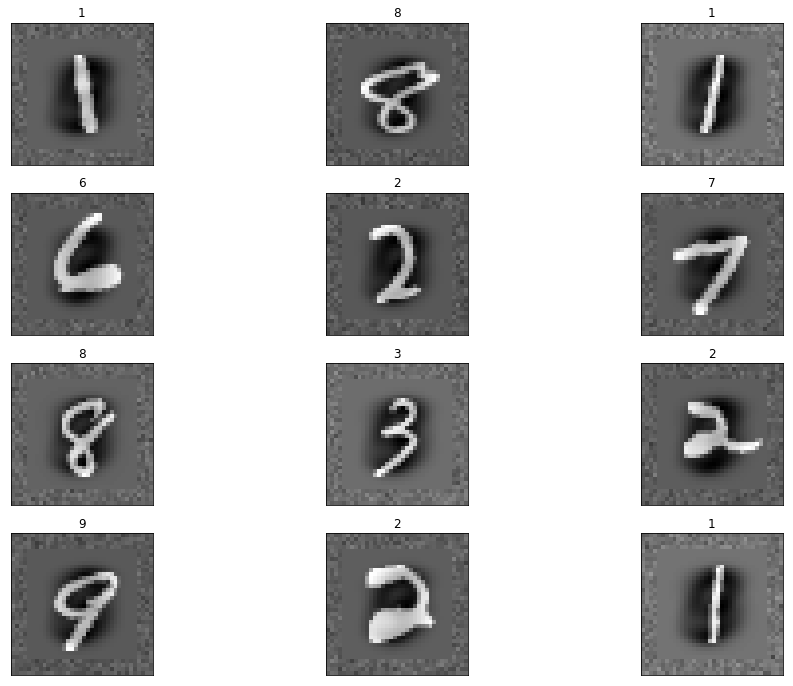

training examples


In [5]:

n_example_to_show = 12  #@param {type: "number"}
sh,sw= 4,int(n_example_to_show/4)
show_test = False
to_show = mod_X_tr
to_target= y_train
if show_test:
  to_show= mod_X_tst
  to_target= y_test
  
if plt_train_examples:
  plt.figure(figsize=(4*sh,4*sw))
  
  for i in range(n_example_to_show):
    k = np.random.randint(ntr)
    plt.subplot(sh,sw,i+1),plt.imshow(to_show[k].reshape((w,h)),'gray')
    plt.title(str(np.argmax(to_target[k])))
    plt.xticks([]),plt.yticks([])


plt.show()
print('training examples')  
  

In [6]:
#@markdown ### Setup a fully connected 2 layer network
# (Turkish: ağı kur)
from keras.regularizers import l2,l1
regit=None
model = Sequential()
model.add(InputLayer(input_shape= (mod_X_tr.shape[1:])))
model.add(Dense(hidden_neurons, activation='relu', kernel_regularizer=regit, name='dense_1'))
#model.add(Dense(hidden_neurons, activation='relu', name='dense_2'))
model.add(Dense(10, activation='softmax', name='dense_softmax'))
model.compile(optimizer=SGD(lr=lr_rate),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

W0805 13:25:32.179467 140336543147904 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0805 13:25:32.200597 140336543147904 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0805 13:25:32.204992 140336543147904 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0805 13:25:32.247300 140336543147904 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0805 13:25:32.257373 140336543147904 deprecation_wrappe

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                12970     
_________________________________________________________________
dense_softmax (Dense)        (None, 10)                110       
Total params: 13,080
Trainable params: 13,080
Non-trainable params: 0
_________________________________________________________________


W0805 13:25:32.293592 140336543147904 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



(1296, 10)


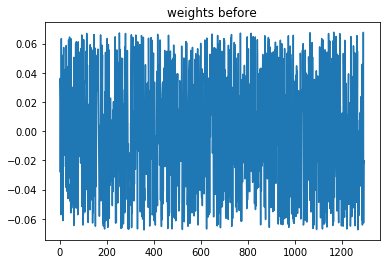

this plot is true only in the first run. model training changes layer weights!      reset and run all to see after model training


In [7]:
#@markdown ### Choose plot parameters

lay_name = 'dense_1'  #@param {type: "string"}
neuron_ix_to_plot_weights = 1 #@param {type: "number"}
#plt.figure(figsize=(10,6))
if plt_weights:
  # get weights for layer 
  probe_layer = model.get_layer(name=lay_name)
  weights = probe_layer.get_weights()[0]
  print(weights.shape)
  #random_neuron_ix = np.random.randint(0,high=weights.shape[1], size=neurons_to_plot)
  weights_to_plot_0 = weights[:,neuron_ix_to_plot_weights]
  plt.figure()
  plt.plot(weights_to_plot_0)
  plt.title('weights before')
  
plt.show()
print('this plot is true only in the first run. model training changes layer weights!\
      reset and run all to see after model training')

In [8]:
#@markdown ### Train and evaluate 
EP =20
BS = 128

history = model.fit(mod_X_tr, y_train,
                    batch_size=BS,
                    epochs=EP,
                    verbose=1,
                    validation_data=(mod_X_tst, y_test))
score = model.evaluate(mod_X_tst, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


W0805 13:25:32.676095 140336543147904 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 1s 20us/step - loss: 1.1439 - acc: 0.6626 - val_loss: 0.6475 - val_acc: 0.8218
Epoch 2/20
60000/60000 [==============================] - 1s 19us/step - loss: 0.5343 - acc: 0.8510 - val_loss: 0.4365 - val_acc: 0.8762
Epoch 3/20
60000/60000 [==============================] - 1s 19us/step - loss: 0.4171 - acc: 0.8800 - val_loss: 0.3740 - val_acc: 0.8908
Epoch 4/20
60000/60000 [==============================] - 1s 19us/step - loss: 0.3703 - acc: 0.8924 - val_loss: 0.3430 - val_acc: 0.8971
Epoch 5/20
60000/60000 [==============================] - 1s 19us/step - loss: 0.3431 - acc: 0.9002 - val_loss: 0.3241 - val_acc: 0.9042
Epoch 6/20
60000/60000 [==============================] - 1s 19us/step - loss: 0.3244 - acc: 0.9058 - val_loss: 0.3111 - val_acc: 0.9078
Epoch 7/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.3102 - acc: 0.9098 - val_loss: 0.3000 - val_acc

(1296, 10)


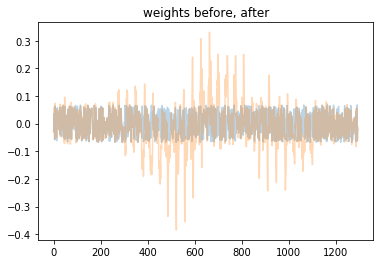

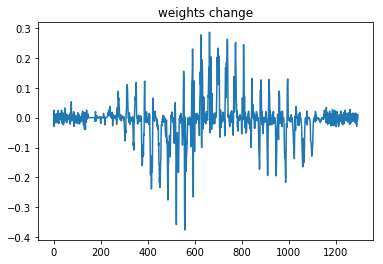

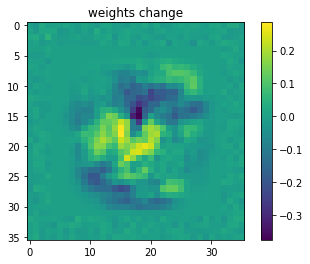

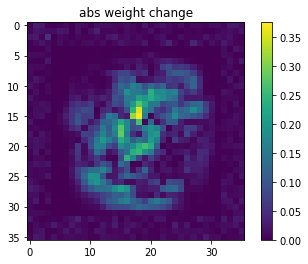

In [14]:
#@markdown ### Lets inspect the layer weights after training
if plt_weights:
  # get weights for layer 
  #probe_layer = model.get_layer(name=lay_name)
  weights = probe_layer.get_weights()[0]
  print(weights.shape)
  
  weights_to_plot_1 = weights[:,neuron_ix_to_plot_weights]
  

  plt.figure()
  plt.plot(weights_to_plot_0, alpha=0.3)
  plt.plot(weights_to_plot_1, alpha=0.3)
  plt.title('weights before, after')
  plt.show()
    
  plt.figure()
  plt.plot(weights_to_plot_1-weights_to_plot_0)
  plt.title('weights change')
  plt.show()
  
  
  weight_diff=(weights_to_plot_1-weights_to_plot_0)
  weight_diff_abs=np.abs(weight_diff)
  plt.figure()
  plt.imshow(np.reshape(weight_diff, newshape=(w,h)))
  plt.title('weights change')
  plt.colorbar()
  plt.show()
  
  plt.figure()
  plt.imshow(np.reshape(weight_diff_abs, newshape=(w,h)))
  plt.title('abs weight change')
  plt.colorbar()
  plt.show()
  
  
 
  


In [10]:
#@title print the first 10 weights
print(weights_to_plot_0[0:10])
#@title
print(weights_to_plot_1[0:10])

[-0.0277046   0.03611346  0.0340184   0.02101541 -0.05718955 -0.05349511
  0.06340226 -0.04055063 -0.02838453  0.00661729]
[-0.03022199  0.00669369  0.05911449  0.01949294 -0.0581587  -0.0500764
  0.07345846 -0.04326747 -0.04485255  0.0180723 ]


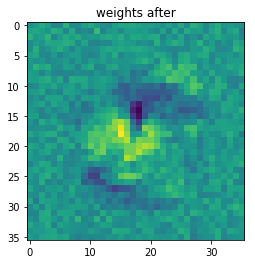

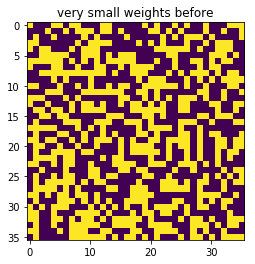

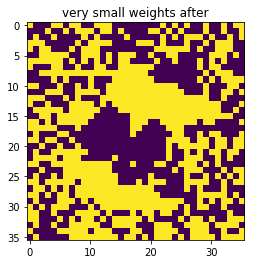

In [11]:
#@title check zero weights
plt.figure()
plt.imshow(np.reshape(weights_to_plot_1, newshape=(w,h)))
plt.title('weights after')
plt.show()

weight_diff=(weights_to_plot_1-weights_to_plot_0)
weight_diff_abs=np.abs(weight_diff)
plt.figure()
plt.imshow(np.reshape(weights_to_plot_0<1e-7, newshape=(w,h)))
plt.title('very small weights before')
plt.show()

plt.figure()
plt.imshow(np.reshape(weights_to_plot_1<1e-7, newshape=(w,h)))
plt.title('very small weights after')
plt.show()



**So, what we see here is that the neuron did not change weights that are attached to the random or constant signals.**

**Why ?**


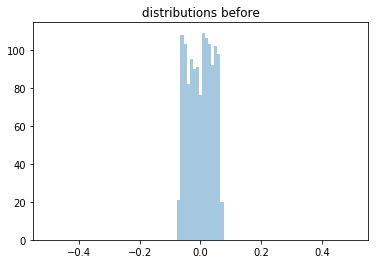

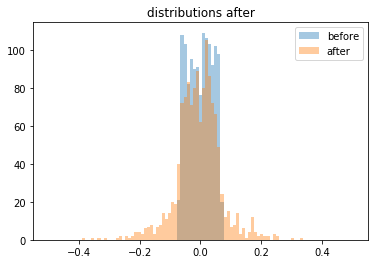

Small weights before: 180
Small weights after: 149


In [12]:
#@title check distributions
plt.figure()
hbins=np.linspace(-0.5,0.5,100)
plt.hist(weights_to_plot_0, hbins, alpha=0.4)
plt.title('distributions before')
plt.show()
 

plt.figure()
plt.hist(weights_to_plot_0, hbins, alpha=0.4)
plt.hist(weights_to_plot_1, hbins, alpha=0.4)
plt.legend(['before', 'after'])
plt.title('distributions after')
plt.show()

print("Small weights before:", np.sum(np.abs(weights_to_plot_0)<=1e-2))
print("Small weights after:", np.sum(np.abs(weights_to_plot_1)<=1e-2))

## Conclusion:


- Do redundant connection weights change if they are attached to a non-zero input signal? Yes, but change is not in a direction to zero out the weight. 

- Which weights do not change at all? The weights attached to constant zero input signals do not change at all. 

- What if we force them, initialize them to be zero? They will get a non-zero value at the first update. They can not remain at zero unless the overall training error is zero. 

- Ok, they do not get zero but is there any trend towards zero? No not all, we do not observe any increase in smaller weights

**Conclusion: a neuron attached to random or constant signal can not break or zero the corresponding connection weight'**

